# Crear Data

In [ ]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import pickle
import time
from bs4 import BeautifulSoup
import os

### 1. Iniciamos sesión y guardamos las cookies para evitar volver a iniciar sesión:
if not os.path.exists(archivo_cookies):
    # Configura tu navegador (en este caso, Chrome)
    driver = webdriver.Chrome()
    
    # Abre la página de Amazon
    driver.get('https://www.amazon.es')
    
    # Espera a que el usuario inicie sesión manualmente
    input("Inicia sesión y presiona Enter para continuar...")
    
    # Guarda las cookies en un archivo
    cookies = driver.get_cookies()  # Obtiene todas las cookies
    with open('amazon_cookies.pkl', 'wb') as f:
        pickle.dump(cookies, f)
    
    print("Cookies guardadas correctamente.")
else:
    print("El archivo de cookies ya existe. No es necesario iniciar sesión nuevamente.")


### 2. Creamos funciones para ayudarnos en la extracción de las reseñas:
def get_reviews_html(driver, product_id, star_filter):
    first_page_url = f"https://www.amazon.es/product-reviews/{product_id}/ref=acr_dp_hist_5?ie=UTF8&filterByStar={star_filter}&reviewerType=all_reviews#reviews-filter-bar"

    html_datas = []
    # Pedimos la página
    driver.get(first_page_url)
    time.sleep(5)  # Espera a que cargue la página

    for i in range (0, 11):
        # Guarda el HTML de la página actual
        html_datas.append(driver.page_source)

        try:
            # Esperar a que el botón "Siguiente" esté presente y sea clickeable
            next_button = WebDriverWait(driver, 5).until(
                EC.element_to_be_clickable((By.CLASS_NAME, "a-last"))
            )

            # Si el botón "Siguiente" está deshabilitado, hemos llegado al final
            if "a-disabled" in next_button.get_attribute("class"):
                print("No hay más páginas de reseñas.")
                break

            # Hacer clic en "Siguiente"
            next_button.click()
            time.sleep(5)  # Esperar a que cargue la nueva página
        except:
            print("No se encontró el botón 'Siguiente' o se llegó al final de las páginas.")
            break  # Salimos del bucle si no se encuentra el botón

    return html_datas
def get_reviews_from_html(page_html: str) -> BeautifulSoup:
    soup = BeautifulSoup(page_html, "lxml")
    reviews = soup.find_all("div", {"class": "a-section celwidget"})
    return reviews

from langdetect import detect

def get_review_text(soup_object: BeautifulSoup) -> str:
    # Extraemos el texto de la reseña
    review_text = soup_object.find(
        "span", {"class": "a-size-base review-text review-text-content"}
    ).get_text()

    # Detectamos el idioma de la reseña
    try:
        lang = detect(review_text)
    except:
        lang = 'unknown'  # En caso de que no se pueda detectar el idioma

    # Filtramos solo las reseñas en español
    if lang == 'es':
        return review_text.strip()
    else:
        return None  # Si no está en español, devolvemos None (o podemos omitirla)

### 3. Obtenemos los ID-s de los productos que nos interesan sus reseñas:
ids = [
    "B0CGXX2HG5",
    "B098RJXBTY",
    "B0D5B6L569",
    "B0CBPP9DBV",
    "B0052X4N8K",
    "B0CHXCQ9B9",
    "B0C5CZ9PW3",
    "B08MLFHTWL",
    "B07H8D895J",
    "B01G7G83TK"
]

### 4. Extraemos las reseñas:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import pickle
import time

# Configura el navegador
driver = webdriver.Chrome()

# Abre Amazon
driver.get('https://www.amazon.es')

# Cargar cookies si existen
try:
    with open('amazon_cookies.pkl', 'rb') as f:
        cookies = pickle.load(f)
        for cookie in cookies:
            driver.add_cookie(cookie)

    driver.refresh()
    print("Cookies cargadas correctamente.")
except FileNotFoundError:
    print("No se encontraron cookies guardadas. Inicia sesión manualmente.")

stars_mapping = {
    'one_star': 1,
    'two_star': 2,
    'three_star': 3,
    'four_star': 4,
    'five_star': 5,
    }

reviews = {1: [],
           2: [],
           3: [],
           4: [],
           5: []}

star_filters = ['one_star', 'two_star', 'three_star', 'four_star', 'five_star']

for i, product_id in enumerate(ids):
    print(f"Extrayendo reseñas del producto Nº{i}.")
    for star_filter in star_filters:
        print(f'Extrayendo reseñas del producto de {star_filter} estrellas...')
        # Obtenemos las páginas HTML de interes
        reviews_html = get_reviews_html(driver, product_id, star_filter)

        for html in reviews_html:
            soup_reviews = get_reviews_from_html(html)

            for soup_review in soup_reviews:
                review_text = get_review_text(soup_review)
                if review_text:  # Solo añade si no es None (es decir, si la reseña está en español)
                    reviews[stars_mapping[star_filter]].append(review_text)


# Cierra el navegador
driver.quit()

### 5. Convertimos las reseñas en un DataFrame:
import pandas as pd

# Inicializamos listas vacías para reseñas y estrellas
review_list = []
stars_list = []

# Recorremos el diccionario y agregamos las reseñas y estrellas a las listas
for stars, review_texts in reviews.items():
    for review in review_texts:
        review_list.append(review)
        stars_list.append(stars)

# Creamos el DataFrame
reviews_df = pd.DataFrame({
    'review': review_list,
    'stars': stars_list
})

# Mostrar el DataFrame
print(reviews_df)

### 6. Guardamos el DataFrame en un archivo .csv:
# Guardar el DataFrame en un archivo CSV
if not os.path.exists('data'):
    os.makedirs('data')
reviews_df.to_csv('data/reviews.csv', index=False)

# Predecir la puntuación de un objeto en Amazon en base a la reseña

In [5]:
import re
import spacy
import pandas as pd
import numpy as np
from spacy.lang.es.stop_words import STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.metrics import confusion_matrix

# Descargar y cargar el modelo de spaCy
tokenizer = spacy.load("es_core_news_sm")

# Cargar dataset desde archivo CSV
file_path = "data/reviews.csv"
df = pd.read_csv(file_path)

# Preprocesamiento sin lematización
def preprocess_text_no_lemma(text):
    text = str(text).lower()
    text = re.sub(r'[^a-záéíóúüñ\s]', '', text)
    tokens = [word for word in text.split() if word not in STOP_WORDS]
    return ' '.join(tokens)

# Preprocesamiento con lematización
def preprocess_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-záéíóúüñ\s]', '', text)
    doc = tokenizer(text)
    tokens = [token.lemma_ for token in doc if token.lemma_ not in STOP_WORDS and not token.is_punct]
    return ' '.join(tokens)

# Aplicar preprocesamiento
df['processed_review_no_lemma'] = df['review'].apply(preprocess_text_no_lemma)
df['processed_review'] = df['review'].apply(preprocess_text)


### Procesamiento y resultados

In [6]:
# Vectorización con TF-IDF (sin y con lematización)
vectorizer_no_lemma = TfidfVectorizer()
vectorizer_lemma = TfidfVectorizer()
X_no_lemma = vectorizer_no_lemma.fit_transform(df['processed_review_no_lemma'])
X_lemma = vectorizer_lemma.fit_transform(df['processed_review'])
y = df['stars']

# Función para entrenamiento y evaluación
def train_and_evaluate(X, y, description):
    if len(df) > 2:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
        smote = SMOTE(random_state=42)
        X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
        
        classifiers = {
            "Logistic Regression": LogisticRegression(max_iter=1000),
            "Naive Bayes": MultinomialNB(alpha=0.1),
            "OVO": OneVsOneClassifier(SVC(kernel='linear', C=1, random_state=42)),
            "OVR": OneVsRestClassifier(SVC(kernel='linear', C=1, random_state=42))
        }
        
        print(f"Resultados para {description}:")
        for name, model in classifiers.items():
            model.fit(X_train_res, y_train_res)
            y_pred = model.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            matrix = confusion_matrix(y_test, y_pred)
            print(matrix)
            print(f'{name} Accuracy: {accuracy:.2f}')
        print("\n")

# Evaluar ambos enfoques
train_and_evaluate(X_no_lemma, y, "TF-IDF sin lematización")
train_and_evaluate(X_lemma, y, "TF-IDF con lematización")

Resultados para TF-IDF sin lematización:
[[14  0  0  4  5]
 [ 3  0  0  2  3]
 [ 1  0  0  2  8]
 [ 3  0  0  4 16]
 [ 4  0  1 10 66]]
Logistic Regression Accuracy: 0.58
[[13  0  1  5  4]
 [ 2  2  0  2  2]
 [ 3  1  1  1  5]
 [ 5  0  1  3 14]
 [ 4  0  4 19 54]]
Naive Bayes Accuracy: 0.50
[[14  0  0  2  7]
 [ 3  0  0  1  4]
 [ 1  0  0  1  9]
 [ 3  0  0  4 16]
 [ 0  0  1  9 71]]
OVO Accuracy: 0.61
[[14  0  0  3  6]
 [ 3  0  0  1  4]
 [ 0  0  1  2  8]
 [ 4  0  0  4 15]
 [ 2  0  3 10 66]]
OVR Accuracy: 0.58


Resultados para TF-IDF con lematización:
[[16  1  1  4  1]
 [ 4  0  0  2  2]
 [ 1  0  1  3  6]
 [ 3  0  1  4 15]
 [ 3  0  3  8 67]]
Logistic Regression Accuracy: 0.60
[[14  1  1  7  0]
 [ 5  0  0  2  1]
 [ 3  1  0  2  5]
 [ 2  0  1  5 15]
 [ 5  0  4 19 53]]
Naive Bayes Accuracy: 0.49
[[14  0  0  4  5]
 [ 4  0  0  1  3]
 [ 0  0  1  3  7]
 [ 2  0  1  4 16]
 [ 2  0  3  7 69]]
OVO Accuracy: 0.60
[[15  1  1  4  2]
 [ 4  0  0  1  3]
 [ 1  0  1  3  6]
 [ 4  0  1  3 15]
 [ 2  0  5  8 66]]
OVR Acc

### Pruebas

In [7]:
# Clasificadores en un ensamblaje (Voting Classifier)
ovo_linear = OneVsRestClassifier(SVC(kernel='linear', probability=True))
logistic = LogisticRegression(max_iter=1000)
naive = MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)

ensemble = VotingClassifier(
    estimators=[('ovo_linear', ovo_linear), ('naive', naive)],
    voting='soft',         
    weights=[0.8, 0.2]
)

ensemble.fit(X_train_res, y_train_res)
y_pred = ensemble.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Ensemble Accuracy with soft voting:", accuracy)

# GridSearchCV para optimizar Naive Bayes
nb = MultinomialNB()
# Definir el espacio de hiperparámetros a buscar
param_grid = {
    'alpha': [0.01, 0.1, 0.5, 1.0, 2.0, 3.0],
    'fit_prior': [True, False],
    'class_prior': [
        None,  # No se especifican probabilidades y se usa el ajuste automático
        [0.1, 0.1, 0.2, 0.3, 0.3],  # Probabilidades distribuidas manualmente
        [0.2, 0.2, 0.2, 0.2, 0.2],  # Probabilidades igualmente distribuidas
        [0.3, 0.2, 0.2, 0.1, 0.2],  # Probabilidades personalizadas
        [0.25, 0.25, 0.25, 0.25, 0.25]  # Otra distribución personalizada
    ]
}
grid_search = GridSearchCV(nb, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_res, y_train_res)
print("Mejores parámetros de Naive Bayes:", grid_search.best_params_)
print("Mejor puntuación de Naive Bayes:", grid_search.best_score_)


# Mostrar algunos ejemplos antes y después del preprocesamiento
num_examples = 5  # Número de ejemplos a imprimir
sample_reviews = df[['review', 'processed_review']].sample(num_examples, random_state=41)

for i, row in sample_reviews.iterrows():
    print(f"🔹 **Texto Original:** {row['review']}")
    print(f"🔹 **Texto Procesado:** {row['processed_review']}")
    print("-" * 80)


Ensemble Accuracy with soft voting: 0.5958904109589042
Mejores parámetros de Naive Bayes: {'alpha': 0.01, 'class_prior': [0.1, 0.1, 0.2, 0.3, 0.3], 'fit_prior': True}
Mejor puntuación de Naive Bayes: 0.93312693498452
🔹 **Texto Original:** Se ha comprado un producto nuevo y el vendedor envía uno usado. La caja está sin precintar y defectuosa por qué se ha utilizado muchas veces. El plástico del consola se ve que no es nuevo tiene muchos usos. Un engaño. Vendedor no es de confianza.
🔹 **Texto Procesado:** comprar producto vendedor enviar usado caja precintar defectuoso utilizar plástico consola engaño vendedor confianza
--------------------------------------------------------------------------------
🔹 **Texto Original:** Para las reuniones familiares no puede faltar
🔹 **Texto Procesado:** reunión familiar faltar
--------------------------------------------------------------------------------
🔹 **Texto Original:** Solo buenas palabras, fui usuario de IOS muchos años y por motivos económic

### Gráficas

C:\Users\Carlos\AppData\Local\Temp\ipykernel_6552\209147315.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='stars', data=df, palette="viridis")


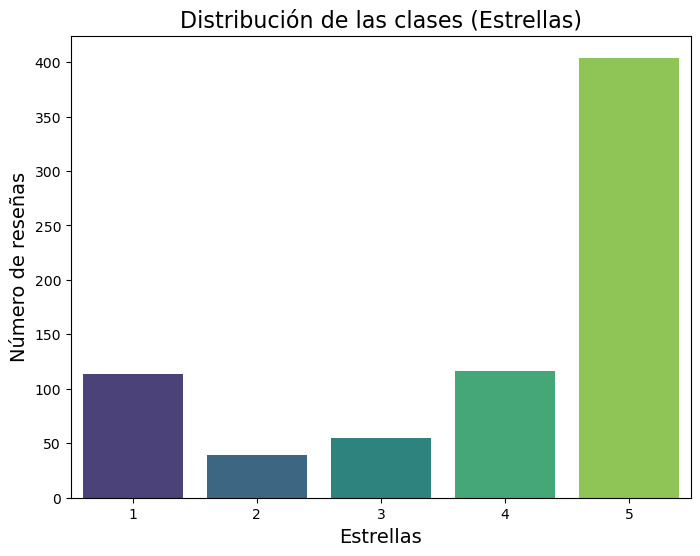

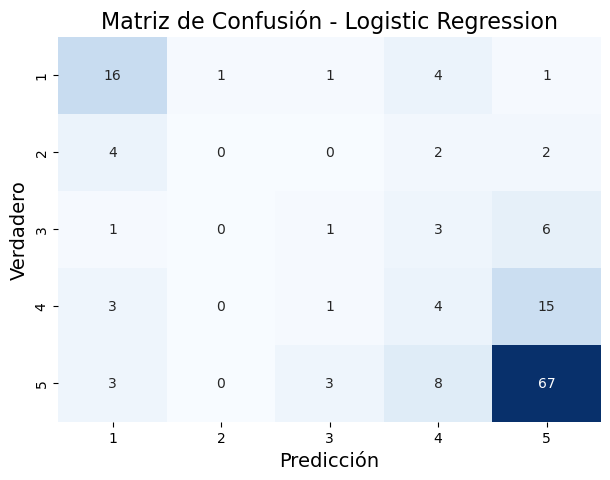

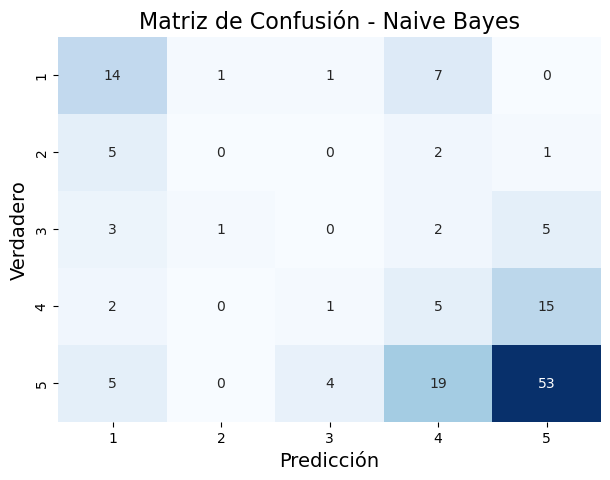

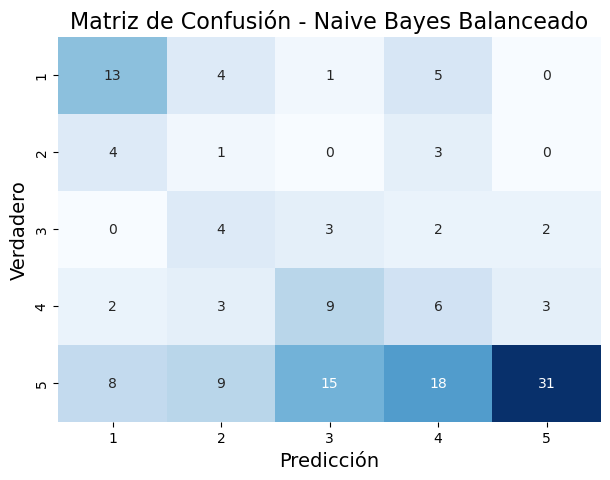

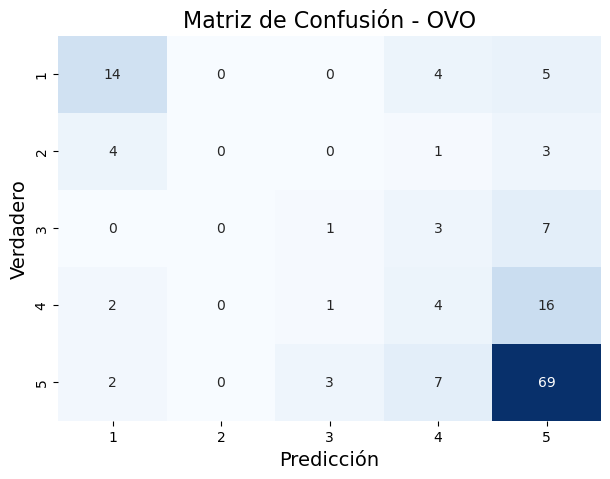

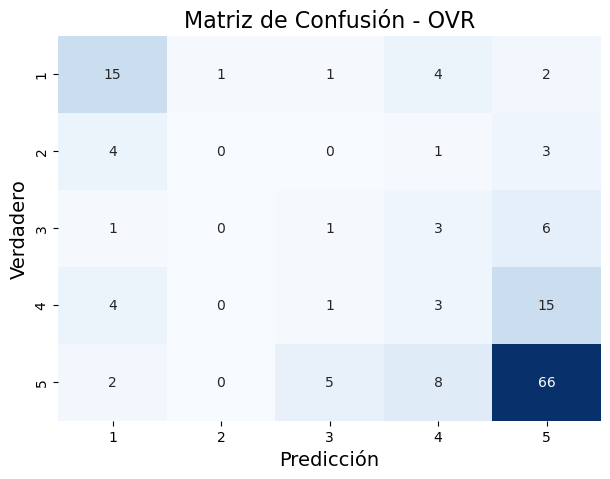

C:\Users\Carlos\AppData\Local\Temp\ipykernel_6552\209147315.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=accuracies, y=models, palette="viridis")


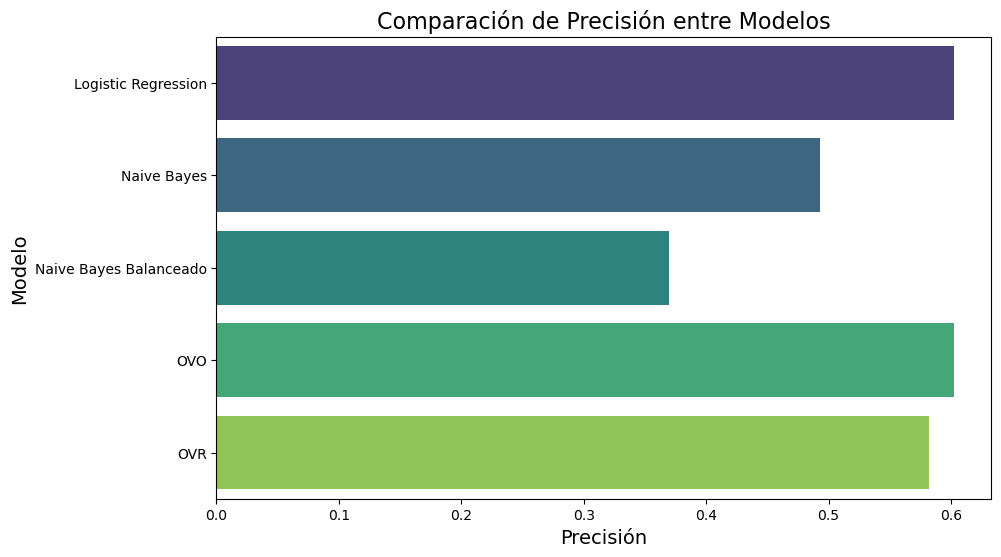

c:\Users\Carlos\anaconda3\envs\py311ml\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128313 (\N{SMALL BLUE DIAMOND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


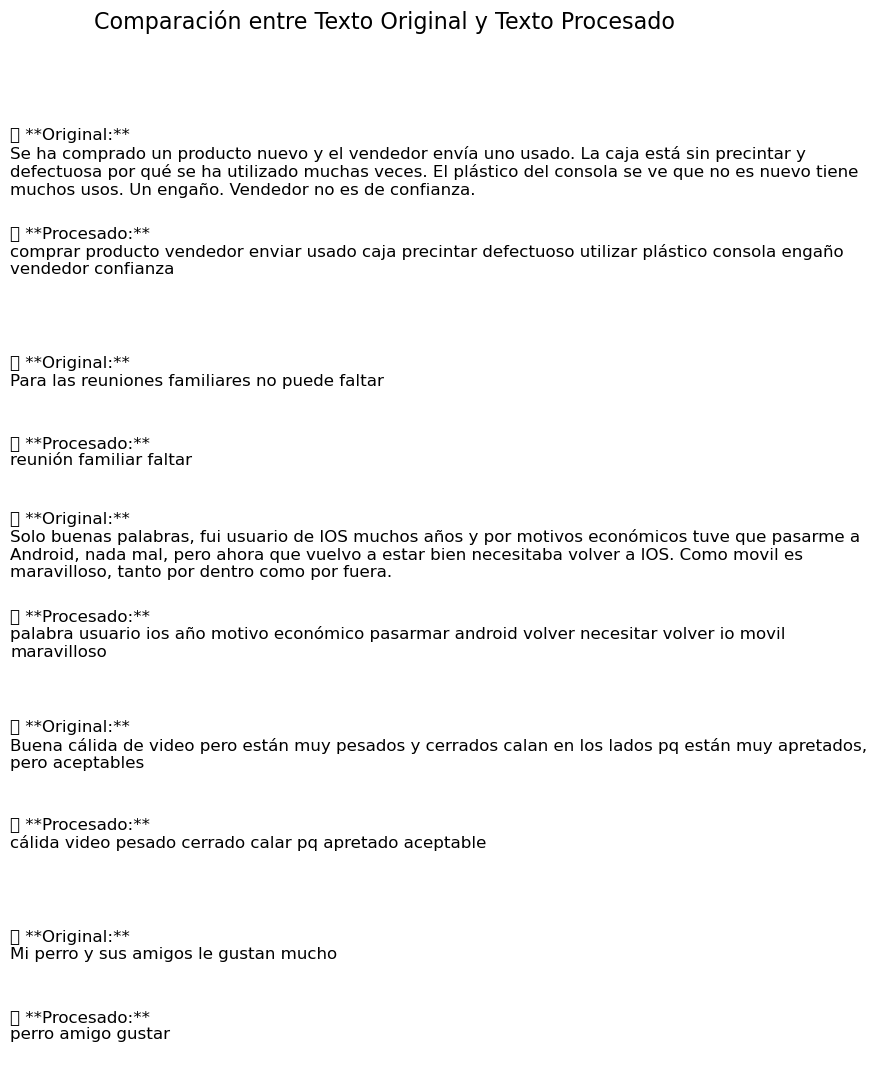

Ensemble Accuracy with soft voting: 0.60


In [8]:
# 1. Distribución de las clases (Etiquetas de estrellas)
plt.figure(figsize=(8, 6))
sns.countplot(x='stars', data=df, palette="viridis")
plt.title('Distribución de las clases (Estrellas)', fontsize=16)
plt.xlabel('Estrellas', fontsize=14)
plt.ylabel('Número de reseñas', fontsize=14)
plt.show()

# 2. Matriz de confusión para cada clasificador
def plot_confusion_matrix(cm, model_name):
    plt.figure(figsize=(7, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, 
                xticklabels=np.unique(y), yticklabels=np.unique(y))
    plt.title(f'Matriz de Confusión - {model_name}', fontsize=16)
    plt.xlabel('Predicción', fontsize=14)
    plt.ylabel('Verdadero', fontsize=14)
    plt.show()

for name, model in classifiers.items():
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(cm, name)

# 3. Comparación de la precisión de los modelos
accuracies = []
models = []

for name, model in classifiers.items():
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)
    models.append(name)

# Plot de comparación de precisiones
plt.figure(figsize=(10, 6))
sns.barplot(x=accuracies, y=models, palette="viridis")
plt.title('Comparación de Precisión entre Modelos', fontsize=16)
plt.xlabel('Precisión', fontsize=14)
plt.ylabel('Modelo', fontsize=14)
plt.show()

# 4. Comparación antes y después del preprocesamiento
num_examples = 5  # Número de ejemplos a imprimir
sample_reviews = df[['review', 'processed_review']].sample(num_examples, random_state=41)

# Preparamos datos para el gráfico de comparación
original_text = sample_reviews['review'].tolist()
processed_text = sample_reviews['processed_review'].tolist()

# Mostrar cambios de texto en gráfico
fig, axes = plt.subplots(nrows=num_examples, ncols=1, figsize=(10, 12))
for i, (original, processed) in enumerate(zip(original_text, processed_text)):
    axes[i].text(0, 0.5, f"🔹 **Original:**\n{original}\n", fontsize=12, wrap=True)
    axes[i].text(0, 0, f"🔹 **Procesado:**\n{processed}\n", fontsize=12, wrap=True)
    axes[i].axis('off')

fig.suptitle("Comparación entre Texto Original y Texto Procesado", fontsize=16)
plt.show()

# 5. Visualización de resultados del ensemble
y_pred_ensemble = ensemble.predict(X_test)
accuracy_ensemble = accuracy_score(y_test, y_pred_ensemble)
print(f"Ensemble Accuracy with soft voting: {accuracy_ensemble:.2f}")

